In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()



In [0]:
X = pd.DataFrame(data.data, columns= data.feature_names)
y = pd.DataFrame(data.target)

In [3]:
print(data.target_names)
df = X.copy()
df['Tumor type'] = y

['malignant' 'benign']


So, 0 is malignant, and 1 is benign... This seems backwards: Let's swap.

In [4]:
def swap01(x):
  if x == 0:
    return 1
  if x == 1:
    return 0

df['Tumor type'] = df['Tumor type'].apply(lambda x : swap01(x))
y[0] = y[0].apply(lambda x :swap01(x))

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Tumor type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


Ok, so now 0 is benign, 1 is malignant. Just guessing here, but it seems reasonable to say benign tumors would be smaller and generally have less texture. Let's see if that's the case:

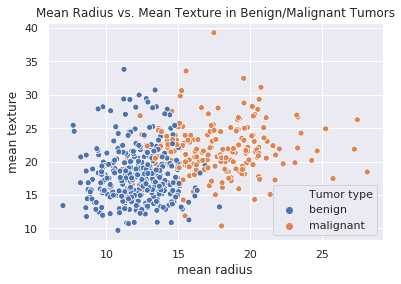

In [5]:
sns.set()
fig, ax = plt.subplots()
ax = sns.scatterplot(x="mean radius", y="mean texture", hue="Tumor type",
                      data=df)
plt.title("Mean Radius vs. Mean Texture in Benign/Malignant Tumors")
leg = plt.legend(loc='lower right')
leg.get_texts()[2].set_text('malignant')
leg.get_texts()[1].set_text('benign')
plt.show()

It looks like texture can vary quite a bit for both classes of tumors.
However, it definitely looks like these two features alone are pretty effective at separating whether the tumor is benign or malignant.
Let's run a logistic regression using just these two features. First, let's split up our data.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, stratify=y, random_state = 20)
y_train = np.array(y_train)
y_test = np.array(y_test)

logreg_X_train = X_train[['mean radius', 'mean texture']]
logreg_X_test = X_test[['mean radius', 'mean texture']]

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.1,max_iter=10000, solver='lbfgs')
logreg.fit(logreg_X_train,y_train.ravel())
logreg_y_pred_train = logreg.predict(logreg_X_train)
logreg_y_pred_test = logreg.predict(logreg_X_test)

Here's how we did on the training and test data, only using these two features:

In [8]:
from sklearn.metrics import mean_squared_error, accuracy_score

def acc(y1,y2):
  classifier_acc_train = accuracy_score(y_train,y1)
  classifier_acc_test = accuracy_score(y_test, y2)
  print("Accuracy the training set is " + str(classifier_acc_train))
  print("Accuracy on the test set is " + str(classifier_acc_test))
  return None

acc(logreg_y_pred_train, logreg_y_pred_test)

Accuracy the training set is 0.9045226130653267
Accuracy on the test set is 0.8654970760233918


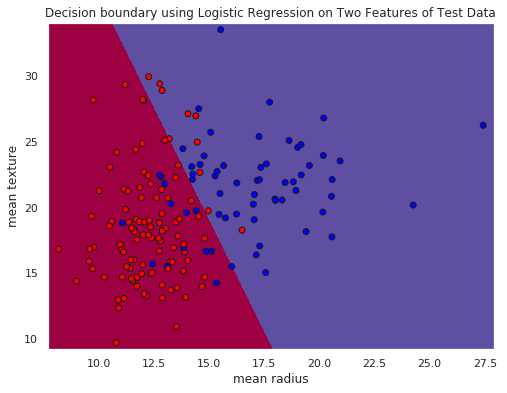

In [9]:
colors = {1: 'blue', 0: 'red'}

x_min, x_max = X_test['mean radius'].values.min() - .5, X_test['mean radius'].values.max() + .5
y_min, y_max = X_test['mean texture'].values.min() - .5, X_test['mean texture'].values.max() + .5
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X_test['mean radius'], X_test['mean texture'], c= list(map(colors.get, y_test.ravel())), label = ['b','m'], edgecolors ='k')
plt.xlabel('mean radius')
plt.ylabel('mean texture')
plt.title('Decision boundary using Logistic Regression on Two Features of Test Data')
plt.show()

Let's do a logistic regression now using all of the features of our data.

In [10]:
logreg2 = LogisticRegression(C=0.1,max_iter=10000, solver='lbfgs')
logreg2.fit(X_train,y_train.ravel())
logreg2_y_pred_train = logreg2.predict(X_train)
logreg2_y_pred_test = logreg2.predict(X_test)
acc(logreg2_y_pred_train, logreg2_y_pred_test)

Accuracy the training set is 0.9547738693467337
Accuracy on the test set is 0.9473684210526315


Ok, 94% accuracy on our test set seems great! However.. there's a couple things I think that should given us caution accuracy as *the*  metric for analyzing our data:

1) Our data is slightly unbalanced:

In [11]:
df.groupby('Tumor type').size()

Tumor type
0    357
1    212
dtype: int64

So we have more benign tumors than malignant ones, meaning if we just guessed that the tumor was benign without putting any thought  into things, we'd be correct about 63% of the time. Another issue:

2) Getting a false negative is a terrible thing: We missed out that someone had a malignant tumor. While getting a false positive isn't great either, missing out on a malignant tumor is more dangerous. 

So, we should aim for high accuracy (taking into account our data is slightly imbalanced), but also aim to minimize the false negative rate.

In [12]:
from sklearn.metrics import confusion_matrix

def fnr(data1,data2):
  tn, fp,  fn, tp =  confusion_matrix(data1, data2).ravel()
  return (fn/(fn + tp))*100

print('The false negative rate on the test set is ' + str(fnr(y_train, logreg2_y_pred_train)) + '%')
print('The false negative rate on the test set is ' + str(fnr(y_test, logreg2_y_pred_test)) + '%')

The false negative rate on the test set is 7.4324324324324325%
The false negative rate on the test set is 9.375%


So,  on our test set we missed 9.4% of the people that actually had a malignant tumor.  Let's try and find a better classifier.

We should also keep in mind we don't have a lot of data here to work with. We should maybe use k-fold  cross validation here on our training data (X_train, y_train) to look for a better model, and then use our test set (X_test, y_test) as a test set at the end once we come up with a better model. From this point on then, we'll rename (X_train, y_train) as (X,y).

In [0]:
X = np.array(X_train)
y = np.array(y_train)

Just to see how it does again, let's run 5-fold validation on our training data, again using logistic regression. This time, we'll add some ($L^{2}$) regularization.

In [18]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits)
logreg3 = LogisticRegression(penalty = 'l2', C=0.1,max_iter=10000, solver='lbfgs')

counter = 0
logreg_accs = []
logreg_fnrs = []
for tr_indx, te_indx in kf.split(X):
  
  counter += 1
  logreg3.fit(X[tr_indx], y[tr_indx].reshape(-1,))
  pred = logreg3.predict(X[te_indx])
  score = accuracy_score(pred, y[te_indx])
  logreg_accs.append(score*100)
  logreg_fnrs.append(fnr(pred, y[te_indx]))
  if counter == n_splits:
    print('Across all folds...')
    print('We had an average accuracy of ' + str(round(np.mean(logreg_accs),2))+ '%' 
          + ' with standard deviation ' + str(round(np.std(logreg_accs),2)) + '% using logistic regression')
    print('We had an average false negative rate of ' + str(round(np.mean(logreg_fnrs),2)) + '%'
         + ' with standard deviation ' + str(round(np.std(logreg_fnrs),2))+ '% using logistic regression')

Across all folds...
We had an average accuracy of 94.72% with standard deviation 1.47% using logistic regression
We had an average false negative rate of 5.64% with standard deviation 1.85% using logistic regression


Keep in mind that our training data here has about 400 people, so that each fold is testing on only 80 people. Let's try a different classifier, like a random forest, and see what happens.

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000,random_state=23,criterion='entropy', max_depth=5)

counter = 0
rfc_accs = []
rfc_fnrs = []
rfc_importances = []
for tr_indx, te_indx in kf.split(X):
  
  counter += 1
  rfc.fit(X[tr_indx], y[tr_indx].reshape(-1,))
  pred = rfc.predict(X[te_indx])
  score = accuracy_score(pred, y[te_indx])
  rfc_accs.append(score*100)
  rfc_fnrs.append(fnr(pred, y[te_indx]))
  rfc_importances.append(list(rfc.feature_importances_))
  if counter == n_splits:
    print('Across all folds...')
    print('We had an average accuracy of ' + str(round(np.mean(rfc_accs),2))+ '%' 
          + ' with standard deviation ' + str(round(np.std(rfc_accs),2)) + '% using a random forest')
    print('We had an average false negative rate of ' + str(round(np.mean(rfc_fnrs),2)) + '%'
         + ' with standard deviation ' + str(round(np.std(rfc_fnrs),2))+ '% using a random forest')


Across all folds...
We had an average accuracy of 95.72% with standard deviation 2.61% using a random forest
We had an average false negative rate of 3.76% with standard deviation 4.44% using a random forest


Alright, a little bit better, but with a little more variance in our false negative rate. Ideally, we'd like a little more consistency in our model. Let's look at which features the random forest thought were important.

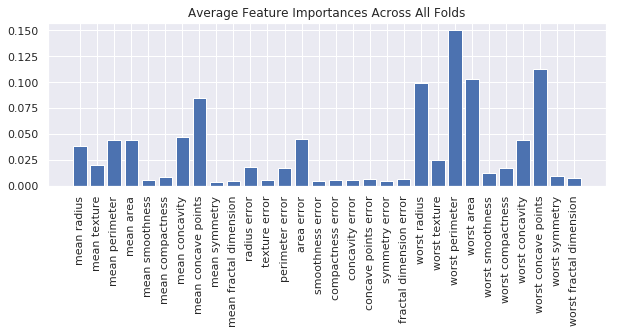

In [20]:
rfc_importances = np.array(rfc_importances)
num_features = X.shape[1]
avg_rfc_importances = []
for i in range(num_features):
  avg_rfc_importances.append( np.mean( rfc_importances[:,i]))

feature_names = list(df.drop(columns='Tumor type', axis=1).columns)
plt.figure(figsize=(10,3))
plt.bar(feature_names, avg_rfc_importances)
plt.title("Average Feature Importances Across All Folds")
plt.xticks(rotation='vertical')
plt.show()

A good chunk of the features here the random forest didn't find particularly useful... we'll keep this in mind going forward. Let's try making a neural network: After tinkering around with some of the parameters, we'll use one with 2 hidden layers and ReLu activation functions.

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_renormed = scaler.transform(X) 

Using TensorFlow backend.


In [22]:
counter = 0
nn_accs = []
nn_fnrs = []
for tr_indx, te_indx in kf.split(X):
  counter += 1
  nnmodel = Sequential()
  nnmodel.add(Dense(30,input_dim=num_features, activation='relu'))
  nnmodel.add(Dense(10, activation='relu'))
  nnmodel.add(Dense(1,activation='sigmoid'))
  nnmodel.compile(loss='binary_crossentropy', optimizer='adam')
  nnmodel.fit(X_renormed[tr_indx], y[tr_indx], epochs=100, verbose=0) 
  X_test_renormed = scaler.transform(X[te_indx])
  pred = nnmodel.predict_classes(X_test_renormed)
  score = accuracy_score(pred, y[te_indx])
  nn_accs.append(score*100)
  nn_fnrs.append(fnr(pred, y[te_indx]))
  if counter == n_splits:
    print('Across all folds...')
    print('We had an average accuracy of ' + str(round(np.mean(nn_accs),2))+ '%' 
          + ' with standard deviation ' + str(round(np.std(nn_accs),2)) + '% using a fully connected network with 2 hidden layers')
    print('We had an average false negative rate of ' + str(round(np.mean(nn_fnrs),2)) + '%'
         + ' with standard deviation ' + str(round(np.std(nn_fnrs),2))+ '% using a fully connected network with 2 hidden layers')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Across all folds...
We had an average accuracy of 97.24% with standard deviation 1.45% using a fully connected network with 2 hidden layers
We had an average false negative rate of 1.42% with standard deviation 1.77% using a fully connected network with 2 hidden layers


This seems like the best model yet. It has high accuracy, the FNR is low, and there's not a whole lot of variance in the model (while the standard deviation is larger than the mean for the FNR... keep in mind that  on our training data of ~400 people, each fold is being tested on 80 people. So an FNR of 1.4% is barely 1 person). 

Let's see if we can tweak this to improve the model. We'll delete some of those features that the random forest thought might not be so useful.

In [0]:
Xnew = pd.DataFrame(X)
useless_features = []
for i in range(num_features):
  if avg_rfc_importances[i] <= 0.02:
    useless_features.append(i)
Xnew = Xnew.drop(columns = useless_features, axis=1)


So, here are the features that the random forest thought were useful (eliminated anything that wasn't used at least 1% of the time on average for each random forest):

In [27]:
for i in Xnew.columns:
   print(data.feature_names[i])

mean radius
mean texture
mean perimeter
mean area
mean concavity
mean concave points
area error
worst radius
worst texture
worst perimeter
worst area
worst concavity
worst concave points


In [0]:
Xnew = np.array(Xnew)

scaler.fit(Xnew)
Xnew_renormed = scaler.transform(Xnew) 

In [30]:

counter = 0
nn2_accs = []
nn2_fnrs = []
for tr_indx, te_indx in kf.split(X):
  counter += 1
  nn2model = Sequential()
  nn2model.add(Dense(40,input_dim=13, activation='relu'))
  nn2model.add(Dense(20, activation='relu'))
  nn2model.add(Dense(10, activation='relu'))
  nn2model.add(Dense(1,activation='sigmoid'))
  nn2model.compile(loss='binary_crossentropy', optimizer='adam')
  nn2model.fit(Xnew_renormed[tr_indx], y[tr_indx], epochs=200, verbose=0) 
  Xnew_test_renormed = scaler.transform(Xnew[te_indx])
  pred = nn2model.predict_classes(Xnew_test_renormed)
  score = accuracy_score(pred, y[te_indx])
  nn2_accs.append(score*100)
  nn2_fnrs.append(fnr(pred, y[te_indx]))
  if counter == n_splits:
    print('Across all folds...')
    print('We had an average accuracy of ' + str(round(np.mean(nn2_accs),2))+ '%' 
          + ' with standard deviation ' + str(round(np.std(nn2_accs),2)) + '% using a fully connected network with 3 hidden layers')
    print('We had an average false negative rate of ' + str(round(np.mean(nn2_fnrs),2)) + '%'
         + ' with standard deviation ' + str(round(np.std(nn2_fnrs),2))+ '% using a fully connected network with 3 hidden layers')

Across all folds...
We had an average accuracy of 95.22% with standard deviation 1.49% using a fully connected network with 3 hidden layers
We had an average false negative rate of 5.6% with standard deviation 1.87% using a fully connected network with 3 hidden layers


Ok, so... looks like some of those features possibly could have been useful after all - we even increased the number of layers and epochs. What if instead of deleting some features, we add in some? Are there any features we could add in? Here's an idea.. I would guess that tumors that are benign are roughly more regularly approximated 
by circles. Thus if we look at $ \frac{ |\text{mean area} - \pi \cdot \text{mean radius}^{2}|}{\text{mean area}} $, this might give us an idea about some inconsistency in the shape of the tumor.

In [0]:
Xnew2 = pd.DataFrame(X)
Xnew2['Homogeneity Measure'] = np.abs(Xnew2[3] - np.pi*(Xnew2[0])**2)/Xnew2[3]
Xnew2 = np.array(Xnew2)

scaler.fit(Xnew2)
Xnew2_renormed = scaler.transform(Xnew2)

Let's use roughly the same architecture for the network we tried the first time, and again go through the training data (across each fold) 100 times. 

In [32]:
counter = 0
nn3_accs = []
nn3_fnrs = []
for tr_indx, te_indx in kf.split(X):
  counter += 1
  nn3model = Sequential()
  nn3model.add(Dense(31,input_dim=num_features + 1, activation='relu'))
  nn3model.add(Dense(10, activation='relu'))
  nn3model.add(Dense(1,activation='sigmoid'))
  nn3model.compile(loss='binary_crossentropy', optimizer='adam')
  nn3model.fit(Xnew2_renormed[tr_indx], y[tr_indx], epochs=100, verbose=0) 
  Xnew2_test_renormed = scaler.transform(Xnew2[te_indx])
  pred = nn3model.predict_classes(Xnew2_test_renormed)
  score = accuracy_score(pred, y[te_indx])
  nn3_accs.append(score*100)
  nn3_fnrs.append(fnr(pred, y[te_indx]))
  if counter == n_splits:
    print('Across all folds...')
    print('We had an average accuracy of ' + str(round(np.mean(nn3_accs),2))+ '%' 
          + ' with standard deviation ' + str(round(np.std(nn3_accs),2)) + '% using a fully connected network with 2 hidden layers')
    print('We had an average false negative rate of ' + str(round(np.mean(nn3_fnrs),2)) + '%'
         + ' with standard deviation ' + str(round(np.std(nn3_fnrs),2))+ '% using a fully connected network with 2 hidden layers')

Across all folds...
We had an average accuracy of 97.23% with standard deviation 0.96% using a fully connected network with 2 hidden layers
We had an average false negative rate of 2.81% with standard deviation 2.67% using a fully connected network with 2 hidden layers


Hard to say if adding this feature did anything worthwhile. The accuracy of our predictions stayed the same, but the variance was slightly lowered, while our false negative rate went up about a percent and had a little more variance. Again, since the sample sizes here are so small, deducing any inferences from this change could be a dangerous conclusion, so the simpler neural network model we had before seems more worthwhile.